In [ ]:
from keras import backend as K
from google.colab import drive
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Dropout, Input, Cropping2D, Add, ZeroPadding2D
from keras.models import Model, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pad_dim = (1200,80,120)
bce = BinaryCrossentropy()

In [ ]:
def calc_cropping_layer(upsample, downsample):
    # Downsample layer is always bigger
    shape_mismatch = tuple(downsample.shape[i]-upsample.shape[i] for i in range(1,3))
    return tuple((i//2, i-i//2) for i in shape_mismatch)

In [ ]:
def dice_coeff(y_true, y_pred):

    smooth=1.

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred,w = (0.5,0.5)):
    return w[0]*(1-dice_coeff(y_true, y_pred)) + w[1]*bce(y_true,y_pred)

In [ ]:
def iou_coeff(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_loss(y_true, y_pred, w = (0.5,0.5)):
    return w[0]*(1-iou_coeff(y_true, y_pred)) + w[1]*bce(y_true, y_pred)

In [ ]:
def iou_dice_loss(y_true, y_pred, w=(0.25, 0.5, 0.5)):
  return w[0]*(1-iou_coeff(y_true,y_pred)) + w[1]*(1-dice_coeff(y_true,y_pred)) + w[2] * bce(y_true, y_pred)

In [ ]:
def build_unet(widths, padshape=(75,100), p=0.1):

    x0 = Input(shape=(padshape[0],padshape[1],1))

    # -- Downsample layers --

    # Block 1
    xd11 = Conv2D(widths['1'], 3 , activation='relu', padding='same')(x0)
    xd11 = BatchNormalization()(xd11)

    xd12 = Conv2D(widths['1'], 3, activation='relu', padding='same')(xd11)
    xd12 = BatchNormalization()(xd12)
    xd12 = Dropout(p)(xd12)

    # Block 2
    xd20 = MaxPooling2D(2)(xd12)
    
    xd21 = Conv2D(widths['2'], 3, activation='relu', padding='same')(xd20)
    xd21 = BatchNormalization()(xd21)

    xd22 = Conv2D(widths['2'], 3, activation='relu', padding='same')(xd21)
    xd22 = BatchNormalization()(xd22)
    xd22 = Dropout(p)(xd22)

    # Block 3
    xd30 = MaxPooling2D(2)(xd22)
    
    xd31 = Conv2D(widths['3'], 3, activation='relu', padding='same')(xd30)
    xd31 = BatchNormalization()(xd31)

    xd32 = Conv2D(widths['3'], 3, activation='relu', padding='same')(xd31)
    xd32 = BatchNormalization()(xd32)
    xd32 = Dropout(p)(xd32)
    
    # Block 4
    xd40 = MaxPooling2D(2)(xd32)
    
    xd41 = Conv2D(widths['4'], 3, activation='relu', padding='same')(xd40)
    xd41 = BatchNormalization()(xd41)

    xd42 = Conv2D(widths['3'], 3, activation='relu', padding='same')(xd41)
    xd42 = BatchNormalization()(xd42)
    xd42 = Dropout(p)(xd42)

    # -- Bottleneck --

    xb = MaxPooling2D(2)(xd42)
    xb1 = Conv2D(widths['bottleneck'], 3, activation='relu', padding='same')(xb)
    xb2 = Conv2D(widths['bottleneck'], 3, activation='relu', padding='same')(xb1)
    xb2 = Dropout(p)(xb2)

    # -- Upsample Layers --    

    # Block 4
    xu40 = Conv2DTranspose(1, 2, strides=2, activation='relu', padding='same')(xb2)    
    crop_dims = calc_cropping_layer(xu40, xd42)
    skip_connection = Cropping2D(crop_dims)(xd42)
    xu40 = Add()([xu40, skip_connection])

    xu41 = Conv2D(widths['3'], 3, activation='relu', padding='same')(xu40)
    xu41 = BatchNormalization()(xu41)

    xu42 = Conv2D(widths['3'], 3, activation='relu', padding='same')(xu41)
    xu42 = BatchNormalization()(xu42)
    xu42 = Dropout(p)(xu42)

    # Block 3

    xu30 = Conv2DTranspose(1, 2, strides=2, activation='relu', padding='same')(xu42)    
    crop_dims = calc_cropping_layer(xu30, xd32)
    skip_connection = Cropping2D(crop_dims)(xd32)
    xu30 = Add()([xu30, skip_connection])

    xu31 = Conv2D(widths['3'], 3, activation='relu', padding='same')(xu30)
    xu31 = BatchNormalization()(xu31)

    xu32 = Conv2D(widths['3'], 3, activation='relu', padding='same')(xu31)
    xu32 = BatchNormalization()(xu32)
    xu32 = Dropout(p)(xu32)

    # Block 2

    xu20 = Conv2DTranspose(1, 2, strides=2 , activation='relu', padding='same')(xu32)
    crop_dims = calc_cropping_layer(xu20,xd22)
    skip_connection = Cropping2D(crop_dims)(xd22)
    xu20 = Add()([xu20, skip_connection])

    xu21 = Conv2D(widths['2'], 3, activation='relu', padding='same')(xu20)
    xu21 = BatchNormalization()(xu21)

    xu22 = Conv2D(widths['2'], 3, activation='relu', padding='same')(xu21)
    xu22 = BatchNormalization()(xu22)
    xu22 = Dropout(p)(xu22)

    # Block 1
    xu10 = Conv2DTranspose(1, 2, strides=2 , activation='relu', padding='same')(xu22)

    crop_dims = calc_cropping_layer(xu10,xd12)
    skip_connection = Cropping2D(crop_dims)(xd12)
    xu10 = Add()([xu10, skip_connection])

    xu11 = Conv2D(widths['1'], 3, activation='relu', padding='same')(xu10)
    xu11 = BatchNormalization()(xu11)

    xu12 = Conv2D(widths['1'], 3, activation='relu', padding='same')(xu11)
    xu12 = BatchNormalization()(xu12)
    xu12 = Dropout(p)(xu12)

    # --- Output Layers ---
    x_out = Conv2D(1, 1, padding='same', activation='sigmoid')(xu12)
    pad_dims = calc_cropping_layer(x_out, x0)
    x_out = ZeroPadding2D(pad_dims)(x_out)

    model = Model(x0, x_out)

    return model


In [ ]:
def get_data(start,stop, padshape=(1200,75,100)):
  X = []
  Y = []
  pad_template = np.zeros(padshape, dtype=np.uint8)
  
  for i in range(start,stop):
    print('importing set %d' %(i))
    paddingX = np.copy(pad_template)
    paddingY = np.copy(pad_template)

    Xi = np.load('./drive/My Drive/Deep_US/npdata/%d_in1.npy'%(i))
    Yi = np.load('./drive/My Drive/Deep_US/npdata/%d_out1.npy'%(i))

    paddingX[:Xi.shape[0], :Xi.shape[1], :Xi.shape[2]] = Xi
    paddingY[:Yi.shape[0], :Yi.shape[1], :Yi.shape[2]] = Yi

    X.extend(paddingX[:Xi.shape[0], :, :])
    Y.extend(paddingY[:Xi.shape[0], :, :])

  return np.expand_dims(np.array(X), axis=3), np.expand_dims(np.array(Y, dtype=np.float32), axis=3)



In [ ]:
X, Y = get_data(1,13, padshape=pad_dim)

importing set 1
importing set 2
importing set 3
importing set 4
importing set 5
importing set 6
importing set 7
importing set 8
importing set 9
importing set 10
importing set 11
importing set 12


(12060, 80, 120, 1)


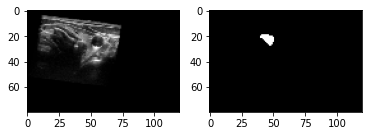

In [ ]:
# Verify data
# See the ROI in Y Labels
print(X.shape)
plt.subplot(1,2,1)
plt.imshow(X[77,:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Y[77,:,:,0], cmap='gray')
plt.show()

In [ ]:
w = {
      '1':8,
      '2':16,
      '3':32,
      '4':64,
      'bottleneck':128
  }

model = build_unet(w, p=0.1, padshape=pad_dim[1:])
model.compile(optimizer=Adam(lr=1e-3), loss=iou_dice_loss, metrics=dice_coeff)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coeff', factor=0.2, mode='max',
                              patience=5, min_lr=1e-5)

history = model.fit(X_train, Y_train, batch_size=256, validation_data=(X_val, Y_val), epochs=50, callbacks=[reduce_lr])

Epoch 1/50
33/33 [==============================] - 16s 324ms/step - loss: 1.0888 - dice_coeff: 0.0128 - val_loss: 1.0587 - val_dice_coeff: 0.0138
Epoch 2/50
33/33 [==============================] - 9s 262ms/step - loss: 1.0350 - dice_coeff: 0.0142 - val_loss: 0.9887 - val_dice_coeff: 0.0118
Epoch 3/50
33/33 [==============================] - 9s 263ms/step - loss: 1.0008 - dice_coeff: 0.0146 - val_loss: 0.9522 - val_dice_coeff: 0.0134
Epoch 4/50
33/33 [==============================] - 9s 262ms/step - loss: 0.9658 - dice_coeff: 0.0166 - val_loss: 0.9088 - val_dice_coeff: 0.0148
Epoch 5/50
33/33 [==============================] - 9s 262ms/step - loss: 0.9291 - dice_coeff: 0.0209 - val_loss: 0.8672 - val_dice_coeff: 0.0205
Epoch 6/50
33/33 [==============================] - 9s 263ms/step - loss: 0.8910 - dice_coeff: 0.0311 - val_loss: 0.8455 - val_dice_coeff: 0.0230
Epoch 7/50
33/33 [==============================] - 9s 264ms/step - loss: 0.8491 - dice_coeff: 0.0460 - val_loss: 0.8372 - 

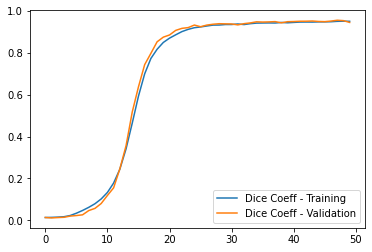

In [ ]:
plt.plot(history.history['dice_coeff'])
plt.plot(history.history['val_dice_coeff'])
plt.legend(['Dice Coeff - Training', 'Dice Coeff - Validation'])
plt.show()

In [ ]:
model.save('./drive/My Drive/Deep_US/roi_model/')

INFO:tensorflow:Assets written to: ./drive/My Drive/Deep_US/roi_model/assets


In [ ]:
# model = load_model('./drive/My Drive/Deep_US/roi_model', compile=False)
# model.compile(optimizer=Adam(lr=1e-3), loss = iou_dice_loss, metrics=dice_coeff)

In [ ]:
# Test set
X_test, Y_test = get_data(13,17, padshape=pad_dim)

importing set 13
importing set 14
importing set 15
importing set 16


In [ ]:
test = model.evaluate(X_test, Y_test, batch_size=256)

13/13 [==============================] - 1s 72ms/step - loss: 0.2860 - dice_coeff: 0.6130


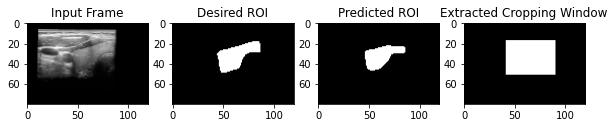

In [ ]:
X_example = X_test[150,:,:,:].reshape(1,pad_dim[1],pad_dim[2],1)
Y_example = Y_test[150,:,:,:]
Y_hat_example = np.squeeze(model.predict(X_example)) > 0.1

ROI = np.zeros_like(Y_hat_example)
y,x = Y_hat_example.nonzero()
ROI[y.min()-5:y.max()+5, x.min()-5:x.max()+5] = 1

plt.figure(figsize=(10,20))
plt.subplot(1,4,1)
plt.imshow(np.squeeze(X_example), cmap='gray')
plt.title('Input Frame')
plt.subplot(1,4,2)
plt.imshow(np.squeeze(Y_example), cmap='gray')
plt.title('Desired ROI')
plt.subplot(1,4,3)
plt.imshow(Y_hat_example, cmap='gray')
plt.title('Predicted ROI')
plt.subplot(1,4,4)
plt.imshow(ROI, cmap='gray')
plt.title('Extracted Cropping Window')
plt.show()

In [ ]:
ROI.max()

True

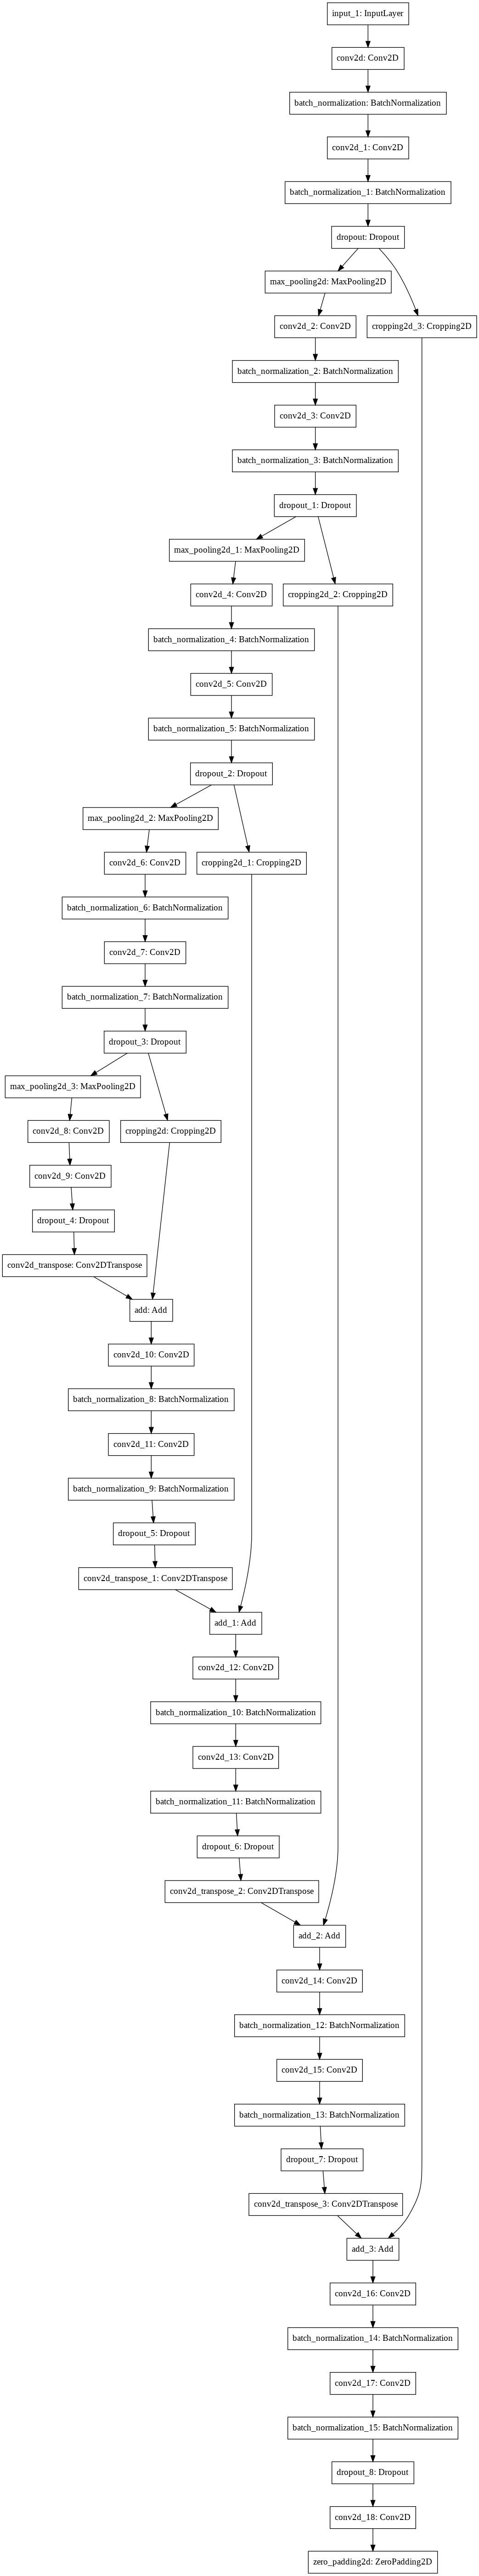

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='./drive/My Drive/Deep_US/model.png')